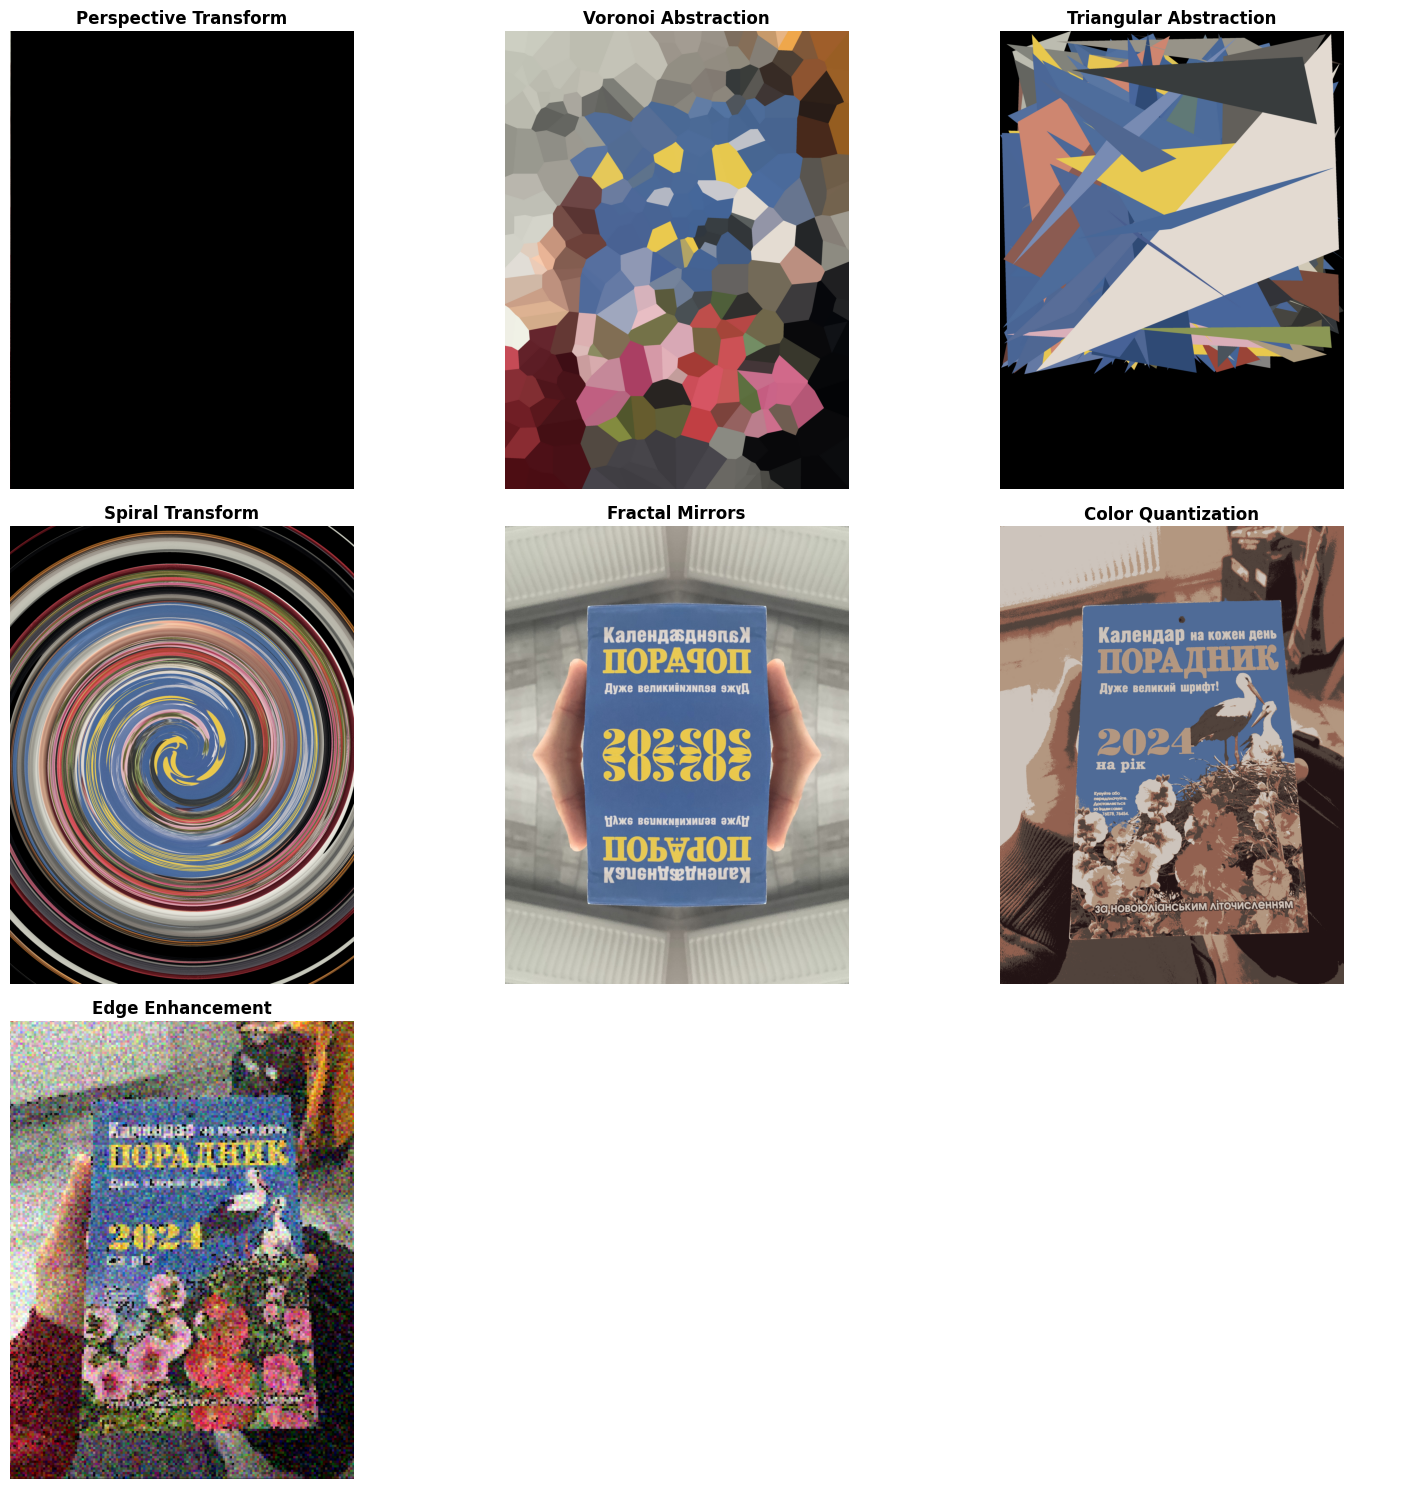

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import random
from typing import Tuple, List

class AbstractArtTransformer:
    def __init__(self, image_path: str):
        """Initialize with input image"""
        self.original = cv2.imread(image_path)
        self.original = cv2.cvtColor(self.original, cv2.COLOR_BGR2RGB)
        self.height, self.width = self.original.shape[:2]
        
    def create_projective_matrix(self, transformation_type: str, **params) -> np.ndarray:
        """Create various projective transformation matrices"""
        if transformation_type == "perspective":
            # Create perspective transformation
            angle = params.get('angle', 0.1)
            return np.array([
                [1, 0, 0],
                [0, 1, 0],
                [angle, 0, 1]
            ], dtype=np.float32)
            
        elif transformation_type == "shear":
            shear_x = params.get('shear_x', 0.2)
            shear_y = params.get('shear_y', 0.1)
            return np.array([
                [1, shear_x, 0],
                [shear_y, 1, 0],
                [0, 0, 1]
            ], dtype=np.float32)
            
        elif transformation_type == "rotation":
            angle = params.get('angle', np.pi/6)
            cos_a, sin_a = np.cos(angle), np.sin(angle)
            cx, cy = self.width//2, self.height//2
            return np.array([
                [cos_a, -sin_a, cx*(1-cos_a) + cy*sin_a],
                [sin_a, cos_a, cy*(1-cos_a) - cx*sin_a],
                [0, 0, 1]
            ], dtype=np.float32)
            
        elif transformation_type == "artistic_warp":
            # Non-linear artistic transformation
            strength = params.get('strength', 0.3)
            return np.array([
                [1+strength*np.sin(0.1), strength*np.cos(0.1), 0],
                [strength*np.sin(0.1), 1+strength*np.cos(0.1), 0],
                [strength*0.001, strength*0.001, 1]
            ], dtype=np.float32)

    def apply_projective_transform(self, matrix: np.ndarray) -> np.ndarray:
        """Apply projective transformation to image"""
        return cv2.warpPerspective(self.original, matrix, (self.width, self.height))

    def create_voronoi_abstraction(self, num_points: int = 200) -> np.ndarray:
        """Create abstract art using Voronoi diagrams"""
        # Generate random points
        points = np.random.rand(num_points, 2)
        points[:, 0] *= self.width
        points[:, 1] *= self.height
        
        # Create Voronoi diagram
        vor = Voronoi(points)
        
        # Create abstract image
        abstract = np.zeros_like(self.original)
        
        # For each pixel, find nearest Voronoi point and sample color from that region
        y_coords, x_coords = np.mgrid[0:self.height, 0:self.width]
        pixel_coords = np.column_stack([x_coords.ravel(), y_coords.ravel()])
        
        # Find nearest Voronoi point for each pixel
        distances = cdist(pixel_coords, points)
        nearest_points = np.argmin(distances, axis=1)
        
        # Sample colors from original image regions
        for i, point in enumerate(points):
            mask = (nearest_points == i).reshape(self.height, self.width)
            if np.any(mask):
                # Sample color from region around this point
                px, py = int(point[0]), int(point[1])
                px = max(0, min(self.width-1, px))
                py = max(0, min(self.height-1, py))
                
                # Get average color in small region around point
                region_size = 10
                x1 = max(0, px - region_size)
                x2 = min(self.width, px + region_size)
                y1 = max(0, py - region_size)
                y2 = min(self.height, py + region_size)
                
                avg_color = np.mean(self.original[y1:y2, x1:x2], axis=(0,1))
                abstract[mask] = avg_color
                
        return abstract.astype(np.uint8)

    def triangular_abstraction(self, num_triangles: int = 150) -> np.ndarray:
        """Create triangular geometric abstraction"""
        abstract = np.zeros_like(self.original)
        
        for _ in range(num_triangles):
            # Random triangle vertices
            pts = np.random.randint(0, min(self.width, self.height), (3, 2))
            pts[:, 0] = np.clip(pts[:, 0], 0, self.width-1)
            pts[:, 1] = np.clip(pts[:, 1], 0, self.height-1)
            
            # Sample color from triangle centroid
            centroid = np.mean(pts, axis=0).astype(int)
            color = self.original[centroid[1], centroid[0]]
            
            # Draw filled triangle
            cv2.fillPoly(abstract, [pts], color.tolist())
            
        return abstract

    def fractal_mirror_transform(self) -> np.ndarray:
        """Apply fractal-like mirror transformations"""
        result = self.original.copy()
        
        # Apply multiple mirror transformations
        transforms = [
            lambda img: cv2.flip(img, 0),  # Vertical flip
            lambda img: cv2.flip(img, 1),  # Horizontal flip
            lambda img: cv2.flip(img, -1), # Both flips
        ]
        
        # Create quadrants with different transformations
        h_mid, w_mid = self.height // 2, self.width // 2
        
        # Top-left: original
        # Top-right: horizontal flip
        result[:h_mid, w_mid:] = cv2.flip(result[:h_mid, :w_mid], 1)
        
        # Bottom-left: vertical flip  
        result[h_mid:, :w_mid] = cv2.flip(result[:h_mid, :w_mid], 0)
        
        # Bottom-right: both flips
        result[h_mid:, w_mid:] = cv2.flip(result[:h_mid, :w_mid], -1)
        
        return result

    def color_quantization_abstract(self, k_colors: int = 8) -> np.ndarray:
        """Abstract through color quantization using K-means"""
        # Reshape image to pixel array
        pixels = self.original.reshape(-1, 3)
        
        # Apply K-means clustering
        kmeans = KMeans(n_clusters=k_colors, random_state=42, n_init=10)
        labels = kmeans.fit_predict(pixels)
        
        # Replace each pixel with its cluster center
        quantized = kmeans.cluster_centers_[labels]
        return quantized.reshape(self.original.shape).astype(np.uint8)

    def spiral_transformation(self, center: Tuple[int, int] = None) -> np.ndarray:
        """Apply spiral transformation matrix"""
        if center is None:
            center = (self.width // 2, self.height // 2)
            
        cx, cy = center
        result = np.zeros_like(self.original)
        
        # Create coordinate grids
        y, x = np.mgrid[0:self.height, 0:self.width]
        
        # Convert to polar coordinates relative to center
        dx, dy = x - cx, y - cy
        r = np.sqrt(dx**2 + dy**2)
        theta = np.arctan2(dy, dx)
        
        # Apply spiral transformation
        spiral_strength = 0.01
        new_theta = theta + spiral_strength * r
        
        # Convert back to Cartesian
        new_x = (r * np.cos(new_theta) + cx).astype(int)
        new_y = (r * np.sin(new_theta) + cy).astype(int)
        
        # Bounds checking
        valid_mask = (new_x >= 0) & (new_x < self.width) & (new_y >= 0) & (new_y < self.height)
        
        result[y[valid_mask], x[valid_mask]] = self.original[new_y[valid_mask], new_x[valid_mask]]
        
        return result

    def edge_enhancement_abstract(self) -> np.ndarray:
        """Create abstract art emphasizing edges and contours"""
        # Convert to grayscale for edge detection
        gray = cv2.cvtColor(self.original, cv2.COLOR_RGB2GRAY)
        
        # Apply multiple edge detection methods
        edges_canny = cv2.Canny(gray, 50, 150)
        edges_sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        edges_sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        edges_sobel = np.sqrt(edges_sobel_x**2 + edges_sobel_y**2)
        
        # Normalize and combine edges
        edges_sobel = np.uint8(edges_sobel / edges_sobel.max() * 255)
        combined_edges = cv2.addWeighted(edges_canny, 0.5, edges_sobel, 0.5, 0)
        
        # Create colorful abstract from edges
        abstract = np.zeros_like(self.original)
        
        # Use original colors where edges are strong
        edge_mask = combined_edges > 100
        abstract[edge_mask] = self.original[edge_mask]
        
        # Fill non-edge areas with artistic patterns
        for i in range(0, self.height, 20):
            for j in range(0, self.width, 20):
                if not edge_mask[i, j]:
                    # Sample nearby colors and create gradient
                    region = self.original[max(0,i-10):min(self.height,i+10), 
                                         max(0,j-10):min(self.width,j+10)]
                    avg_color = np.mean(region, axis=(0,1))
                    
                    # Apply color with some randomness
                    noise = np.random.normal(0, 30, 3)
                    final_color = np.clip(avg_color + noise, 0, 255)
                    
                    abstract[max(0,i-10):min(self.height,i+10), 
                           max(0,j-10):min(self.width,j+10)] = final_color
        
        return abstract.astype(np.uint8)

    def generate_abstract_art_pipeline(self, style: str = "mixed") -> List[np.ndarray]:
        """Generate multiple abstract art variations"""
        results = []
        
        if style in ["mixed", "geometric"]:
            # 1. Projective transformations
            perspective_matrix = self.create_projective_matrix("perspective", angle=0.15)
            perspective_art = self.apply_projective_transform(perspective_matrix)
            results.append(("Perspective Transform", perspective_art))
            
            # 2. Voronoi abstraction
            voronoi_art = self.create_voronoi_abstraction(num_points=300)
            results.append(("Voronoi Abstraction", voronoi_art))
            
            # 3. Triangular abstraction
            triangle_art = self.triangular_abstraction(num_triangles=200)
            results.append(("Triangular Abstraction", triangle_art))
        
        if style in ["mixed", "mathematical"]:
            # 4. Spiral transformation
            spiral_art = self.spiral_transformation()
            results.append(("Spiral Transform", spiral_art))
            
            # 5. Fractal mirrors
            mirror_art = self.fractal_mirror_transform()
            results.append(("Fractal Mirrors", mirror_art))
        
        if style in ["mixed", "color"]:
            # 6. Color quantization
            quantized_art = self.color_quantization_abstract(k_colors=6)
            results.append(("Color Quantization", quantized_art))
            
            # 7. Edge-based abstraction
            edge_art = self.edge_enhancement_abstract()
            results.append(("Edge Enhancement", edge_art))
        
        return results

    def visualize_transformations(self, results: List[Tuple[str, np.ndarray]]):
        """Visualize all transformations in a grid"""
        n_transforms = len(results)
        cols = 3
        rows = (n_transforms + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
        axes = axes.flatten() if n_transforms > 1 else [axes]
        
        for i, (title, image) in enumerate(results):
            axes[i].imshow(image)
            axes[i].set_title(title, fontsize=12, fontweight='bold')
            axes[i].axis('off')
        
        # Hide empty subplots
        for i in range(n_transforms, len(axes)):
            axes[i].axis('off')
            
        plt.tight_layout()
        plt.show()

    def demonstrate_matrix_transformations(self):
        """Demonstrate fundamental matrix transformations"""
        print("Matrix Transformation Examples:")
        print("=" * 40)
        
        # Show different transformation matrices
        matrices = {
            "Identity": np.eye(3),
            "Rotation (30°)": self.create_projective_matrix("rotation", angle=np.pi/6),
            "Shear": self.create_projective_matrix("shear", shear_x=0.3, shear_y=0.1),
            "Perspective": self.create_projective_matrix("perspective", angle=0.2)
        }
        
        for name, matrix in matrices.items():
            print(f"\n{name} Matrix:")
            print(matrix)
            
            # Show effect on unit square corners
            corners = np.array([[0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]]).T
            transformed = matrix @ corners
            # Convert from homogeneous coordinates
            transformed_2d = transformed[:2] / transformed[2]
            
            print(f"Unit square corners: {corners[:2].T}")
            print(f"After transformation: {transformed_2d.T}")

# Example usage and tutorial
def run_transformation_tutorial(image_path: str):
    """Complete tutorial for transforming selfie to abstract art"""
    
    print("🎨 Selfie to Abstract Art Transformation Tutorial")
    print("=" * 50)
    
    # Initialize transformer
    transformer = AbstractArtTransformer(image_path)
    
    # Demonstrate matrix concepts
    transformer.demonstrate_matrix_transformations()
    
    print("\n🔄 Generating Abstract Art Variations...")
    
    # Generate different styles
    geometric_results = transformer.generate_abstract_art_pipeline("geometric")
    mathematical_results = transformer.generate_abstract_art_pipeline("mathematical") 
    color_results = transformer.generate_abstract_art_pipeline("color")
    
    # Visualize results
    print("\n📊 Visualizing Geometric Abstractions:")
    transformer.visualize_transformations(geometric_results)
    
    print("\n📊 Visualizing Mathematical Transformations:")
    transformer.visualize_transformations(mathematical_results)
    
    print("\n📊 Visualizing Color Abstractions:")
    transformer.visualize_transformations(color_results)
    
    # Create combined masterpiece
    print("\n🎭 Creating Combined Masterpiece...")
    all_results = geometric_results + mathematical_results + color_results
    
    # Select best transformations and combine
    selected = [all_results[i][1] for i in [0, 2, 4, 6]]  # Pick diverse ones
    
    # Create 2x2 composition
    top_row = np.hstack([selected[0], selected[1]])
    bottom_row = np.hstack([selected[2], selected[3]])
    masterpiece = np.vstack([top_row, bottom_row])
    
    plt.figure(figsize=(12, 12))
    plt.imshow(masterpiece)
    plt.title("Abstract Art Masterpiece", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    return transformer, all_results

# Advanced transformation class for more complex effects
class AdvancedAbstractTransformer(AbstractArtTransformer):
    
    def parametric_surface_mapping(self, u_func, v_func) -> np.ndarray:
        """Map image onto parametric surface"""
        result = np.zeros_like(self.original)
        
        # Create parameter space
        u = np.linspace(0, 1, self.width)
        v = np.linspace(0, 1, self.height)
        U, V = np.meshgrid(u, v)
        
        # Apply parametric functions
        X = u_func(U, V) * self.width
        Y = v_func(U, V) * self.height
        
        # Bounds checking and mapping
        valid_mask = (X >= 0) & (X < self.width) & (Y >= 0) & (Y < self.height)
        X_int = X[valid_mask].astype(int)
        Y_int = Y[valid_mask].astype(int)
        
        # Map colors
        v_coords, u_coords = np.where(valid_mask)
        result[v_coords, u_coords] = self.original[Y_int, X_int]
        
        return result
    
    def complex_plane_transformation(self) -> np.ndarray:
        """Transform using complex plane mathematics"""
        # Create complex coordinate system
        x = np.linspace(-2, 2, self.width)
        y = np.linspace(-2, 2, self.height)
        X, Y = np.meshgrid(x, y)
        Z = X + 1j * Y
        
        # Apply complex function (example: z^2 + c)
        c = 0.3 + 0.5j
        W = Z**2 + c
        
        # Map back to image coordinates
        new_x = (W.real + 2) / 4 * self.width
        new_y = (W.imag + 2) / 4 * self.height
        
        # Create abstract image
        result = np.zeros_like(self.original)
        
        valid_mask = (new_x >= 0) & (new_x < self.width) & (new_y >= 0) & (new_y < self.height)
        new_x_int = new_x[valid_mask].astype(int)
        new_y_int = new_y[valid_mask].astype(int)
        
        y_coords, x_coords = np.where(valid_mask)
        result[y_coords, x_coords] = self.original[new_y_int, new_x_int]
        
        return result

# Usage example:
"""
# To use this code:

"""
# 1. Basic transformation

transformer = AbstractArtTransformer('/Users/agerasymchuk/private_repo/cv_claude_course/cv_course/images/IMG_1814.jpg')
results = transformer.generate_abstract_art_pipeline("mixed")
transformer.visualize_transformations(results)

# # 2. Run full tutorial
# transformer, all_results = run_transformation_tutorial('your_selfie.jpg')

# # 3. Advanced transformations
# advanced = AdvancedAbstractTransformer('your_selfie.jpg')

# # Parametric surface example (sine wave)
# sine_art = advanced.parametric_surface_mapping(
#     lambda u, v: u + 0.1 * np.sin(10 * v),
#     lambda u, v: v + 0.1 * np.cos(10 * u)
# )

# # Complex plane transformation
# complex_art = advanced.complex_plane_transformation()

# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(advanced.original)
# plt.title('Original')
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.imshow(sine_art)
# plt.title('Parametric Surface')
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.imshow(complex_art)
# plt.title('Complex Plane Transform')
# plt.axis('off')

# plt.show()
